In [2]:
import torch

num_gpus = torch.cuda.device_count()
num_cpus = torch.get_num_threads()

print(f"Number of available CPU cores: {num_cpus}")
print(f"Number of available GPUs: {num_gpus}")

Number of available CPU cores: 1
Number of available GPUs: 1


In [3]:
!pip install torch torchvision albumentations

In [4]:
!git clone https://github.com/aliabbasi2000/PIDNet.git
%cd /content/PIDNet/

Cloning into 'PIDNet'...
remote: Enumerating objects: 595, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 595 (delta 17), reused 17 (delta 8), pack-reused 558 (from 1)
Receiving objects: 100% (595/595), 246.53 MiB | 18.01 MiB/s, done.
Resolving deltas: 100% (245/245), done.
Updating files: 100% (130/130), done.
/content/PIDNet


In [5]:
!wget https://zenodo.org/record/5706578/files/Train.zip
!wget https://zenodo.org/record/5706578/files/Val.zip
!unzip Train.zip -d ./LoveDA
!unzip Val.zip -d ./LoveDA

Streaming output truncated to the last 5000 lines.
 extracting: ./LoveDA/Train/Urban/images_png/2025.png  
 extracting: ./LoveDA/Train/Urban/images_png/2026.png  
 extracting: ./LoveDA/Train/Urban/images_png/2027.png  
 extracting: ./LoveDA/Train/Urban/images_png/2028.png  
 extracting: ./LoveDA/Train/Urban/images_png/2029.png  
 extracting: ./LoveDA/Train/Urban/images_png/2030.png  
  inflating: ./LoveDA/Train/Urban/images_png/2031.png  
 extracting: ./LoveDA/Train/Urban/images_png/2032.png  
 extracting: ./LoveDA/Train/Urban/images_png/2033.png  
  inflating: ./LoveDA/Train/Urban/images_png/2034.png  
  inflating: ./LoveDA/Train/Urban/images_png/2035.png  
 extracting: ./LoveDA/Train/Urban/images_png/2036.png  
 extracting: ./LoveDA/Train/Urban/images_png/2037.png  
 extracting: ./LoveDA/Train/Urban/images_png/2038.png  
 extracting: ./LoveDA/Train/Urban/images_png/2039.png  
 extracting: ./LoveDA/Train/Urban/images_png/2040.png  
 extracting: ./LoveDA/Train/Urban/images_png/2041.png

In [6]:
!wget --content-disposition "https://drive.usercontent.google.com/u/0/uc?id=1hIBp_8maRr60-B3PF0NVtaA6TYBvO4y-&export=download"
!mv PIDNet_S_ImageNet.pth.tar /content/PIDNet/pretrained_models/imagenet

--2025-01-18 20:13:16--  https://drive.usercontent.google.com/u/0/uc?id=1hIBp_8maRr60-B3PF0NVtaA6TYBvO4y-&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.107.132, 2607:f8b0:400e:c09::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.107.132|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://drive.usercontent.google.com/uc?id=1hIBp_8maRr60-B3PF0NVtaA6TYBvO4y-&export=download [following]
--2025-01-18 20:13:16--  https://drive.usercontent.google.com/uc?id=1hIBp_8maRr60-B3PF0NVtaA6TYBvO4y-&export=download
Reusing existing connection to drive.usercontent.google.com:443.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1hIBp_8maRr60-B3PF0NVtaA6TYBvO4y-&export=download [following]
--2025-01-18 20:13:16--  https://drive.usercontent.google.com/download?id=1hIBp_8maRr60-B3PF0NVtaA6TYBvO4y-&export=download
Reusing e

In [7]:
import os
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
from albumentations import Compose, Normalize, Resize
from albumentations.pytorch import ToTensorV2
import cv2

class LoveDADataset(Dataset):
    def __init__(self, root, split='train', region='urban', transform=None):
        self.root = root
        self.split = split
        self.region = region
        self.image_dir = os.path.join(root, split, region, 'images_png')
        self.mask_dir = os.path.join(root, split, region, 'masks_png')
        self.images = sorted(os.listdir(self.image_dir))
        self.masks = sorted(os.listdir(self.mask_dir))
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
      image_path = os.path.join(self.image_dir, self.images[idx])
      mask_path = os.path.join(self.mask_dir, self.masks[idx])

      # Load the image and mask
      image = cv2.imread(image_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
      mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

      # Convert mask to tensor and shift labels
      mask = np.array(mask, dtype=np.int64) - 1  # Shift labels to range [0, 6]
      mask = np.clip(mask, 0, num_classes - 1)  # Ensure no negative values

      # Apply transformations if specified
      if self.transform:
          augmented = self.transform(image=image, mask=mask)
          image = augmented["image"]
          mask = augmented["mask"]

      # Convert to PyTorch tensors
      image = image.clone().detach().float()  # HWC to CHW
      mask = mask.clone().detach().long()

      return image, mask


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [8]:
from torch.utils.data import DataLoader
from albumentations import Compose, HorizontalFlip, RandomRotate90, Resize, Normalize
from torchvision.transforms import ToTensor
from torchvision import transforms
from albumentations.pytorch import ToTensorV2

train_transform = Compose([
    Resize(512, 512),  # Resize both image and mask
    #####    AUGMENTATION HERE      #######
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
    ToTensorV2()  # Convert to PyTorch tensors
])

# Define transforms for the evaluation phase

eval_transform = Compose([
    Resize(512, 512),  # Resize to match the input size of the model
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize with ImageNet stats
    ToTensorV2()  # Convert to PyTorch tensors
])

# Define dataset paths
data_root = '/content/PIDNet/LoveDA'


# Load datasets
train_dataset = LoveDADataset(root=data_root, split='Train', region='Urban', transform=train_transform)
val_dataset = LoveDADataset(root=data_root, split='Val', region='Urban', transform=eval_transform)


# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)



In [9]:
import torch
from models.pidnet import get_seg_model
import yaml

## get_pred ------------------------------------
#model = get_pred_model('pidnet_s', num_classes=7)

## get_seg ------------------------------------
# Convert the dictionary to a DotDict
class DotDict(dict):
    """A dictionary that supports attribute-style access."""
    def __getattr__(self, name):
        value = self.get(name)
        if isinstance(value, dict):
            return DotDict(value)
        return value

    def __setattr__(self, name, value):
        self[name] = value

# Load the YAML configuration
with open('/content/PIDNet/configs/loveda/pidnet_small_loveda.yaml', 'r') as f:
    cfg_dict = yaml.safe_load(f)

# Convert to DotDict for attribute-style access
cfg = DotDict(cfg_dict)

imgnet = 'imagenet' in cfg.MODEL.PRETRAINED

model = get_seg_model(cfg, imgnet_pretrained=imgnet)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)




/content/PIDNet/models/pidnet.py:194: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_state = torch.load(cfg.MODEL.PRETRAINED, map_location='cpu')['state_dict']


In [10]:
import torch.nn as nn

criterion = nn.CrossEntropyLoss(ignore_index=-1)

# Change the LR to 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)


In [11]:
!pip install ptflops

In [12]:
!pip install torchinfo

In [14]:
import torch.nn.functional as F
from torchinfo import summary
import time
import numpy as np

def calculate_iou(predictions, ground_truth, num_classes):
    classwise_iou = []
    for cls in range(num_classes):
        tp = ((predictions == cls) & (ground_truth == cls)).sum().item()
        fp = ((predictions == cls) & (ground_truth != cls)).sum().item()
        fn = ((predictions != cls) & (ground_truth == cls)).sum().item()

        if tp + fp + fn == 0:
            iou = float('nan')
        else:
            iou = tp / (tp + fp + fn)
        classwise_iou.append(iou)

    return classwise_iou

# Training
model.train()
num_epochs = 20
num_classes = 7
class_labels = ["background", "building", "road", "water", "barren", "forest", "agriculture"]
epoch_train_miou = []  # To store training mIoU per epoch
epoch_val_miou = []    # To store validation mIoU per epoch

final_avg_latency = 0.0
final_flops = 0.0
final_params = 0

for epoch in range(num_epochs):
    # Training phase
    train_loss = 0.0
    total_latency = 0.0
    train_classwise_iou = np.zeros(num_classes)
    num_batches = 0

    model.train()
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        start_time = time.time()
        outputs = model(images)
        latency = time.time() - start_time
        total_latency += latency

        outputs = outputs[0]
        masks = F.interpolate(masks.unsqueeze(1).float(), size=(outputs.shape[2], outputs.shape[3]), mode='nearest').squeeze(1).long()
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        batch_iou = calculate_iou(preds, masks, num_classes)
        train_classwise_iou += np.nan_to_num(batch_iou)
        num_batches += 1

    train_loss /= len(train_loader)
    avg_latency = total_latency / len(train_loader)
    mean_classwise_iou = train_classwise_iou / num_batches
    train_mean_iou = np.nanmean(mean_classwise_iou)
    epoch_train_miou.append(train_mean_iou)

    if epoch == num_epochs - 1:  # Save latency, FLOPs, and Params only for the final epoch
        final_avg_latency = avg_latency
        flops_summary = summary(model, input_size=(1, *images.shape[1:]), verbose=0)
        final_flops = flops_summary.total_mult_adds
        final_params = flops_summary.total_params

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Training mIoU: {train_mean_iou:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_classwise_iou = np.zeros(num_classes)
    num_batches = 0

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            outputs = outputs[0]
            masks = F.interpolate(masks.unsqueeze(1).float(), size=(outputs.shape[2], outputs.shape[3]), mode='nearest').squeeze(1).long()
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            batch_iou = calculate_iou(preds, masks, num_classes)
            val_classwise_iou += np.nan_to_num(batch_iou)
            num_batches += 1

    val_loss /= len(val_loader)
    mean_classwise_iou = val_classwise_iou / num_batches
    val_mean_iou = np.nanmean(mean_classwise_iou)
    epoch_val_miou.append(val_mean_iou)

    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation mIoU: {val_mean_iou:.4f}")

# Print final results
print(f"\nFinal Average Latency: {final_avg_latency:.4f} seconds")
print(f"Final FLOPs: {final_flops:.2f}")
print(f"Final Params: {final_params}")

print("Class-wise IoU:")
for cls, label in enumerate(class_labels):
    print(f"  {label}: {mean_classwise_iou[cls]:.4f}")

Epoch 1/20, Training Loss: 1.4572, Training mIoU: 0.2602
Epoch 1/20, Validation Loss: 1.7660, Validation mIoU: 0.2682
Epoch 2/20, Training Loss: 1.0435, Training mIoU: 0.3198
Epoch 2/20, Validation Loss: 1.6031, Validation mIoU: 0.2966
Epoch 3/20, Training Loss: 0.9656, Training mIoU: 0.3506
Epoch 3/20, Validation Loss: 1.5825, Validation mIoU: 0.3076
Epoch 4/20, Training Loss: 0.8958, Training mIoU: 0.3761
Epoch 4/20, Validation Loss: 1.5358, Validation mIoU: 0.3347
Epoch 5/20, Training Loss: 0.8472, Training mIoU: 0.3924
Epoch 5/20, Validation Loss: 1.4795, Validation mIoU: 0.3544
Epoch 6/20, Training Loss: 0.8084, Training mIoU: 0.4183
Epoch 6/20, Validation Loss: 1.3668, Validation mIoU: 0.3617
Epoch 7/20, Training Loss: 0.7815, Training mIoU: 0.4322
Epoch 7/20, Validation Loss: 1.4295, Validation mIoU: 0.3641
Epoch 8/20, Training Loss: 0.7593, Training mIoU: 0.4403
Epoch 8/20, Validation Loss: 1.2986, Validation mIoU: 0.3796
Epoch 9/20, Training Loss: 0.7318, Training mIoU: 0.4562

Class-wise IoU:
  background: 0.3932
  building: 0.4864
  road: 0.4809
  water: 0.5638
  barren: 0.1374
  forest: 0.3847
  agriculture: 0.3084


Average Latency: 0.0466 seconds, FLOPs: 6277026048.00, Params: 7717839, mIoU: 0.3984

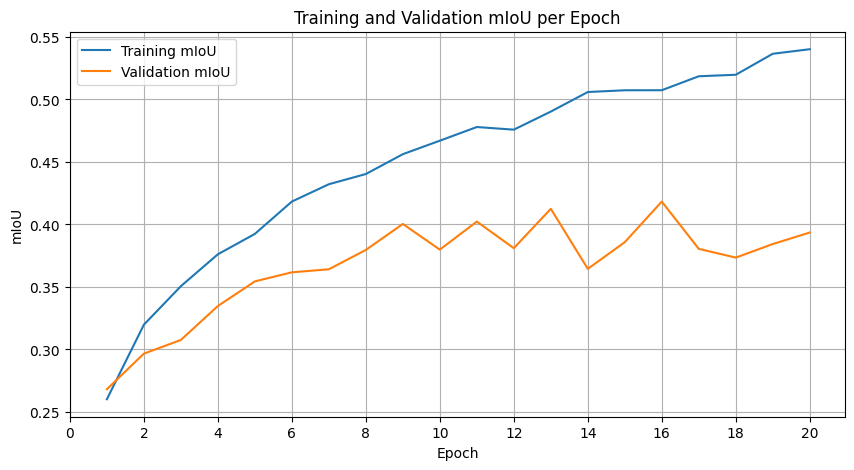

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), epoch_train_miou, label='Training mIoU')
plt.plot(range(1, num_epochs + 1), epoch_val_miou, label='Validation mIoU')
plt.xlabel('Epoch')
plt.ylabel('mIoU')
plt.title('Training and Validation mIoU per Epoch')
plt.legend()
plt.grid(True)
plt.xticks(range(0, num_epochs + 2, 2))
plt.show()

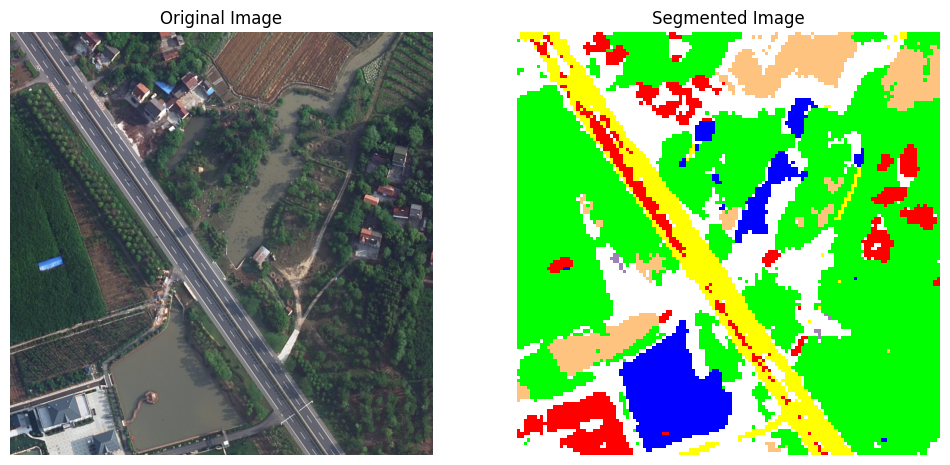

In [50]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# Define label colors (R, G, B) for each class
class_labels = ["background", "building", "road", "water", "barren", "forest", "agriculture"]
label_colors = {
    "background": (255, 255, 255),        # White
    "building": (255, 0, 0),             # Red
    "road": (255, 255, 0),               # Yellow
    "water": (0, 0, 255),                # Blue
    "barren": (159, 129, 183),           # Purple
    "forest": (0, 255, 0),               # Green
    "agriculture": (255, 195, 128)       # Peach
}

# Load a single image for segmentation
image_path = "/content/PIDNet/LoveDA/Test/Rural"
image_files = [f for f in os.listdir(image_path) if os.path.isfile(os.path.join(image_path, f)) and not f.startswith('.')]
image_name = image_files[0]
image = Image.open(os.path.join(image_path, image_name)).convert('RGB')



# Preprocess the image (resize, normalize, etc.)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_image = transform(image).unsqueeze(0).to(device)

# Perform inference with the model
model.eval()
with torch.no_grad():
    output = model(input_image)  # Shape: (1, num_classes, H, W)
    output = output[0]  # Remove auxiliary outputs if present
    preds = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()  # Shape: (H, W)

# Create a segmentation map
segmentation_map = np.zeros((preds.shape[0], preds.shape[1], 3), dtype=np.uint8)

for label_index, label_name in enumerate(class_labels):
    color = label_colors[label_name]
    segmentation_map[preds == label_index] = color

# Visualize the original image and segmentation map
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(segmentation_map)
plt.title("Segmented Image")
plt.axis("off")

plt.show()


lr=0.0001 with get_seg_model and no Augmentaton

Epoch 1/20, Training Loss: 2.4444

Epoch 2/20, Training Loss: 1.0701

Epoch 3/20, Training Loss: 0.9237

Epoch 4/20, Training Loss: 0.8490

Epoch 5/20, Training Loss: 0.8123

Epoch 6/20, Training Loss: 0.7760

Epoch 7/20, Training Loss: 0.7406

Epoch 8/20, Training Loss: 0.7166

Epoch 9/20, Training Loss: 0.7035

Epoch 10/20, Training Loss: 0.6739

Epoch 11/20, Training Loss: 0.6632

Epoch 12/20, Training Loss: 0.6406

Epoch 13/20, Training Loss: 0.6309

Epoch 14/20, Training Loss: 0.6130

Epoch 15/20, Training Loss: 0.5988

Epoch 16/20, Training Loss: 0.5808

Epoch 17/20, Training Loss: 0.5695

Epoch 18/20, Training Loss: 0.5514

Epoch 19/20, Training Loss: 0.5384

Epoch 20/20, Training Loss: 0.5337

Validation Loss: 1.3866, Validation mIoU: 0.
4003

Class-wise IoU:
  background: 0.3970
  building: 0.4901
  road: 0.4872
  water: 0.5724
  barren: 0.1795
  forest: 0.3789
  agriculture: 0.2972

lr=0.0001 with get_seg_model and no Augmentaton

Epoch 1/20, Training Loss: 2.4444

Epoch 2/20, Training Loss: 1.0701

Epoch 3/20, Training Loss: 0.9237

Epoch 4/20, Training Loss: 0.8490

Epoch 5/20, Training Loss: 0.8123

Epoch 6/20, Training Loss: 0.7760

Epoch 7/20, Training Loss: 0.7406

Epoch 8/20, Training Loss: 0.7166

Epoch 9/20, Training Loss: 0.7035

Epoch 10/20, Training Loss: 0.6739

Epoch 11/20, Training Loss: 0.6632

Epoch 12/20, Training Loss: 0.6406

Epoch 13/20, Training Loss: 0.6309

Epoch 14/20, Training Loss: 0.6130

Epoch 15/20, Training Loss: 0.5988

Epoch 16/20, Training Loss: 0.5808

Epoch 17/20, Training Loss: 0.5695

Epoch 18/20, Training Loss: 0.5514

Epoch 19/20, Training Loss: 0.5384

Epoch 20/20, Training Loss: 0.5337

Validation Loss: 1.3866, Validation mIoU: 0.
4003

Class-wise IoU:
  background: 0.3970
  building: 0.4901
  road: 0.4872
  water: 0.5724
  barren: 0.1795
  forest: 0.3789
  agriculture: 0.2972

lr=0.001 with get_seg_model and no Augmentaton

Epoch 1/20, Training Loss: 1.2298

Epoch 2/20, Training Loss: 0.8423

Epoch 3/20, Training Loss: 0.7903

Epoch 4/20, Training Loss: 0.7484

Epoch 5/20, Training Loss: 0.7174

Epoch 6/20, Training Loss: 0.6909

Epoch 7/20, Training Loss: 0.6650

Epoch 8/20, Training Loss: 0.6434

Epoch 9/20, Training Loss: 0.6311

Epoch 10/20, Training Loss: 0.6088

Epoch 11/20, Training Loss: 0.5884

Epoch 12/20, Training Loss: 0.5825

Epoch 13/20, Training Loss: 0.5921

Epoch 14/20, Training Loss: 0.6201

Epoch 15/20, Training Loss: 0.5601

Epoch 16/20, Training Loss: 0.5268

Epoch 17/20, Training Loss: 0.5025

Epoch 18/20, Training Loss: 0.4817

Epoch 19/20, Training Loss: 0.4652

Epoch 20/20, Training Loss: 0.4583

Validation Loss: 1.7222, Validation mIoU: 0.
3525

Class-wise IoU:
  background: 0.3929
  building: 0.3826
  road: 0.4954
  water: 0.5617
  barren: 0.0301
  forest: 0.3851
  agriculture: 0.2197

Results with LR = 0.001 & no augmentation & get_pred_model

Epoch 1/20, Training Loss: 1.5734

Epoch 2/20, Training Loss: 1.2186

Epoch 3/20, Training Loss: 1.1586

Epoch 4/20, Training Loss: 1.0996

Epoch 5/20, Training Loss: 1.0738

Epoch 6/20, Training Loss: 1.0270

Epoch 7/20, Training Loss: 1.0056

Epoch 8/20, Training Loss: 0.9661

Epoch 9/20, Training Loss: 0.9684

Epoch 10/20, Training Loss: 0.9254

Epoch 11/20, Training Loss: 0.9302

Epoch 12/20, Training Loss: 0.8847

Epoch 13/20, Training Loss: 0.8708

Epoch 14/20, Training Loss: 0.8504

Epoch 15/20, Training Loss: 0.8547

Epoch 16/20, Training Loss: 0.8067

Epoch 17/20, Training Loss: 0.8353

Epoch 18/20, Training Loss: 0.7776

Epoch 19/20, Training Loss: 0.7593

Epoch 20/20, Training Loss: 0.7456

Validation Loss: 1.5764, Validation mIoU: 0.2721

Class-wise IoU:
  background: 0.3529
  building: 0.2585
  road: 0.3466
  water: 0.3753
  barren: 0.0935
  forest: 0.3289
  agriculture: 0.1492